# Evaluation of all models. LR, SVC, KNN, DTC, SGDC, NB, RF, and DeepLearning

In [1]:
# combined_evaluation.py

# Import necessary libraries
import numpy as np
import pandas as pd
import pickle

# TensorFlow Keras for Deep Learning Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

# Scikit-learn for Machine Learning Models
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Define function to round metric results
def round_up_metric_results(results):
    return list(map(lambda el: round(el, 3), results))

# Load the test dataset
def load_test_data(test_csv_path, scaler_path):
    df = pd.read_csv(test_csv_path)

    # Encode labels
    df.loc[df["label"] == "down", "label"] = 0
    df.loc[df["label"] == "up", "label"] = 1

    # Load the scaler and transform features
    with open(scaler_path, "rb") as f:
        sc = pickle.load(f)
    X = df.drop("label", axis=1)
    X_scaled = pd.DataFrame(sc.transform(X))

    y = df["label"].astype(int)
    y_cat = to_categorical(y)

    return X_scaled, y, y_cat

# Load test data
test_csv_path = "./test.csv"
scaler_path = "./model/input_scaler.pkl"  # Ensure this scaler is compatible with both models
X_test, y_test, y_test_cat = load_test_data(test_csv_path, scaler_path)

# Load Deep Learning Model
with open("./model/squat_dp.pkl", "rb") as f:
    deep_learning_model = pickle.load(f)

# Load Machine Learning Model
with open("./model/LR_model.pkl", "rb") as f:
    machine_learning_model = pickle.load(f)

# Evaluate Deep Learning Model
dl_predict_prob = deep_learning_model.predict(X_test, verbose=False)
dl_predictions = np.argmax(dl_predict_prob, axis=1)

dl_cm = confusion_matrix(y_test, dl_predictions, labels=[0, 1])
dl_p_score, dl_r_score, dl_f_score, _ = precision_recall_fscore_support(
    y_test, dl_predictions, labels=[0, 1]
)

# Evaluate Machine Learning Model
ml_predictions = machine_learning_model.predict(X_test)

ml_cm = confusion_matrix(y_test, ml_predictions, labels=[0, 1])
ml_p_score, ml_r_score, ml_f_score, _ = precision_recall_fscore_support(
    y_test, ml_predictions, labels=[0, 1]
)

# Prepare results for comparison
results = {
    "Model": ["Deep Learning", "Machine Learning"],
    "Precision Score": [
        round_up_metric_results(dl_p_score),
        round_up_metric_results(ml_p_score),
    ],
    "Recall Score": [
        round_up_metric_results(dl_r_score),
        round_up_metric_results(ml_r_score),
    ],
    "F1 Score": [
        round_up_metric_results(dl_f_score),
        round_up_metric_results(ml_f_score),
    ],
    "Confusion Matrix": [dl_cm, ml_cm],
}

# Display the results in a DataFrame
results_df = pd.DataFrame(results)
print(results_df)


              Model Precision Score    Recall Score        F1 Score  \
0     Deep Learning  [0.995, 0.998]  [0.998, 0.995]  [0.997, 0.996]   
1  Machine Learning  [0.993, 0.998]  [0.998, 0.993]  [0.995, 0.995]   

       Confusion Matrix  
0  [[429, 1], [2, 421]]  
1  [[429, 1], [3, 420]]  


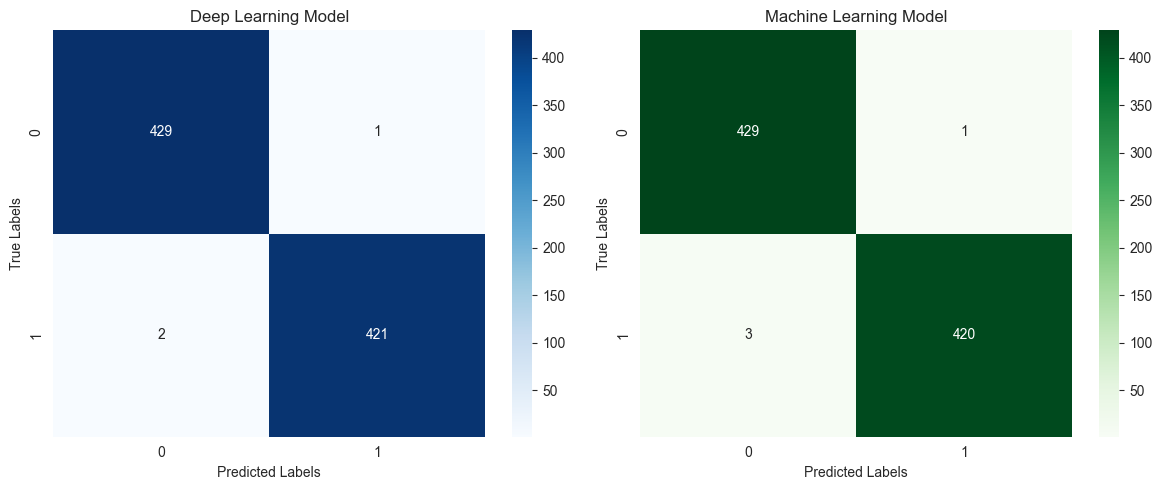

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(results['Confusion Matrix'][0], annot=True, fmt='g', ax=axes[0], cmap='Blues')
axes[0].set_title('Deep Learning Model')
axes[0].set_xlabel('Predicted Labels')
axes[0].set_ylabel('True Labels')

sns.heatmap(results['Confusion Matrix'][1], annot=True, fmt='g', ax=axes[1], cmap='Greens')
axes[1].set_title('Machine Learning Model')
axes[1].set_xlabel('Predicted Labels')
axes[1].set_ylabel('True Labels')

plt.tight_layout()
plt.show()
